# Text Clssification Mini Project 2

## 1. Data Loading and Exploration

### 1.1 Importing the necessary libraries:

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import nltk
import re
import math
from nltk.tokenize import word_tokenize

# Import Additional Libraries
import contractions
import string
from nrclex import NRCLex
from textblob import TextBlob

# Import Spacy libary
import spacy
# Load the pre-trained spaCy model
nlp = spacy.load('en_core_web_sm')

### 1.2 Data Loading

Read positive and negative reviews

In [4]:
# Read positive and negative reviews

positive_reviews = open('Mini_Project_2_Data/positive-reviews.txt', encoding='utf-8').read().splitlines()
negative_reviews = open('Mini_Project_2_Data/negative-reviews.txt', encoding='utf-8').read().splitlines()

Read positive and negative words from files

In [5]:
# Read positive and negative words from files

positive_words = set(open('Mini_Project_2_Data/positive-words.txt').read().splitlines())
negative_words = set(open('Mini_Project_2_Data/negative-words.txt').read().splitlines())

Combine to Dataframe

In [6]:
# Combine negative and positive reviews
reviews = negative_reviews + positive_reviews

# Create a DataFrame with a 'Reviews' column
df = pd.DataFrame({'Reviews': reviews})

# Create labels
labels = [0] * len(negative_reviews) + [1] * len(positive_reviews)

# Add a 'Label' column to the DataFrame
df['Label'] = labels


In [7]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Reviews,Label
0,"8x optical zoom, Rotatable lens, Large LCD screen",1
1,Versatility,1
2,"Inexpensive, good quality print, ease of use",1
3,"Easy to use, great navigation system, great co...",1
4,Incredible features. Incredible resolution. In...,1
...,...,...
39995,paper jams in some printers-not mine-rare,0
39996,Easy to use and versatile.,1
39997,"Battery Life, Shutter Speed is temperamental a...",0
39998,"BATTERY LIFE, reception",0


<Axes: xlabel='Label'>

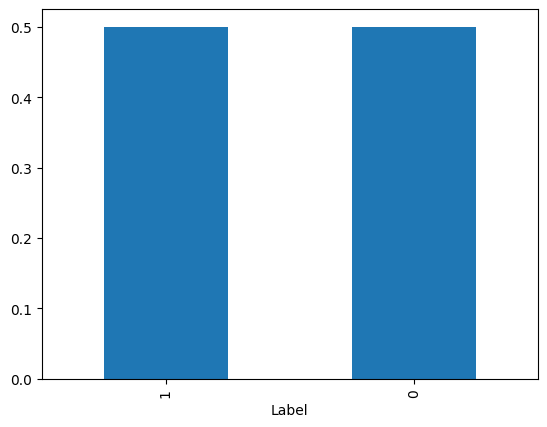

In [8]:
df['Label'].value_counts(normalize = True).plot.bar()

## 2. Text Preprocessing and Cleaning


### 2.1 Cleaning 

In [9]:
# Remove newline characters from the 'review_text' column
df['Reviews'] = df['Reviews'].str.strip()

In [10]:
# Check if there are None rows
none_rows = df[df['Reviews'] == 'None']
none_rows

,Reviews,Label
233,None,0
421,None,0
702,None,0
781,None,0
989,None,0
...,...,...
39784,None,0
39843,None,0
39884,None,0
39897,None,0


In [11]:
# Filter rows where 'review_text' is not 'None'
df = df[df['Reviews'] != 'None']

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Check if there are None rows
none_rows = df[df['Reviews'] == 'None']
none_rows

,Reviews,Label


+ Check Duplicate Data

In [12]:
df.duplicated().sum()

3151

In [13]:
df = df.drop_duplicates()
df.duplicated().sum()

0

+ Check if it null

In [14]:
df.isnull().sum()

Reviews    0
Label      0
dtype: int64

### 2.2 Text Preprocessing

Define a function for text preprocessing and store the results in a new column called **'cleaned_review_text'**.

1. **Remove extra spaces**:
   - Using regular expressions, eliminate any redundant spaces within the text.

2. **Convert text to lowercase**:
   - Convert all characters in the text to lowercase to ensure uniformity.

3. **Expand contractions**:
   - Utilize the `contractions.fix()` function to expand contracted words in the text.

4. **Replace repetitions of punctuation with a single punctuation**:
   - Employ regular expressions to replace consecutive occurrences of punctuation with a single instance.

5. **Remove punctuation (except '!') and numbers**:
   - Use regular expressions to eliminate all punctuation marks and numerical digits from the text, with the exception of the exclamation mark '!'.

6. **Remove emojis**:
   - Utilize either regular expressions or a library to remove emojis from the text.

7. **Tokenize text**:
   - Segment the text into individual words or tokens using a tokenizer.

8. **Remove stop words except 'no' and 'not'**:
   - Exclude common stop words, which are words that typically do not carry significant meaning, from the text. However, retain the words 'no' and 'not' as they can alter the meaning of a sentence.

9. **Lemmatization**:
   - Apply lemmatization to reduce each word to its base or dictionary form, considering the context of the word in the sentence.

10. **Join tokens back into text**:
    - Reassemble the processed tokens into coherent text after preprocessing.



In [15]:
def text_preprocessing(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Convert text to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Replace repetitions of punctuation with a single punctuation mark
    text = re.sub(r'(\W)\1+', r'\1', text)

    # Remove punctuation(except !) and numbers
    text = re.sub(r'[^a-zA-Z!]+', ' ', text)

    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Tokenize text using SpaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stop words except 'no' and 'not' - SpaCy has its own stop words list
    tokens = [token for token in tokens if not nlp.vocab[token].is_stop or token in {'no', 'not'}]

    # Lemmatization - SpaCy performs lemmatization automatically
    tokens = [token.lemma_ for token in doc]

    # Return Join tokens back into text
    cleaned_text = ' '.join(tokens)

    return cleaned_text



+ Apply clean text to datafram

In [16]:
# Apply the function to the 'review_text' column and store the results in a new column 'cleaned_review_text'
df['cleaned_review_text'] = df['Reviews'].apply(text_preprocessing)

df

,Reviews,Label,cleaned_review_text
0,"8x optical zoom, Rotatable lens, Large LCD screen",1,x optical zoom rotatable lens large lcd screen
1,Versatility,1,versatility
2,"Inexpensive, good quality print, ease of use",1,inexpensive good quality print ease of use
3,"Easy to use, great navigation system, great co...",1,easy to use great navigation system great colo...
4,Incredible features. Incredible resolution. In...,1,incredible feature incredible resolution incre...
...,...,...,...
39696,paper jams in some printers-not mine-rare,0,paper jam in some printer not mine rare
39697,Easy to use and versatile.,1,easy to use and versatile
39698,"Battery Life, Shutter Speed is temperamental a...",0,battery life shutter speed be temperamental an...
39699,"BATTERY LIFE, reception",0,battery life reception


### 2.3 Data Virtualization 

## 3. Feature Extraction from Text

### 3.1 Count of Positive and Negative Words in Review Text
This analysis provides a breakdown of the number of positive and negative words found in the review text. Positive and negative sentiments are quantified to gain insights into the overall tone of the reviews.


In [17]:
def count_positive_words(text):

    words = text.lower().split()
    count = sum(1 for word in words if word in positive_words)
    return count

def count_negative_words(text):

    words = text.lower().split()
    count = sum(1 for word in words if word in negative_words)
    return count

+ Apply count_negative_words and count_positive_words

In [18]:
# Apply function count_positive_words and count_negative_words to cleaned_review_text
df['count_positive_words'] = df['cleaned_review_text'].apply(count_positive_words)
df['count_negative_words'] = df['cleaned_review_text'].apply(count_negative_words)

### 3.2 Check for Presence of 'no' or 'not' in Review Text
This analysis examines whether the review text includes the words 'no' or 'not'. Identifying the presence of these words can be crucial for understanding negation in the sentiment expressed within the reviews.


In [19]:
def contain_no(cleaned_review_text):
    tokens = word_tokenize(cleaned_review_text)
    contain_no = int('no' in tokens)
    return contain_no

def contain_not(cleaned_review_text):
    tokens = word_tokenize(cleaned_review_text)
    contain_not = int('not' in tokens)
    return contain_not

+ Apply function contains_no and contains_not to cleaned_review_text

In [20]:
# Apply function contains_no and contains_not to cleaned_review_text
df['contain_no'] = df['cleaned_review_text'].apply(contain_no)
df['contain_not'] = df['cleaned_review_text'].apply(contain_not)

In [21]:
df.head(10)

,Reviews,Label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not
0,"8x optical zoom, Rotatable lens, Large LCD screen",1,x optical zoom rotatable lens large lcd screen,0,0,0,0
1,Versatility,1,versatility,1,0,0,0
2,"Inexpensive, good quality print, ease of use",1,inexpensive good quality print ease of use,3,0,0,0
3,"Easy to use, great navigation system, great co...",1,easy to use great navigation system great colo...,5,0,0,0
4,Incredible features. Incredible resolution. In...,1,incredible feature incredible resolution incre...,4,0,0,0
5,"uphill learning curve, for an old SLR guy",0,uphill learn curve for an old slr guy,0,0,0,0
6,"Sleek design, accessories, mail-in rebate",1,sleek design accessory mail in rebate,1,0,0,0
7,"Size, style, features",1,size style feature,0,0,0,0
8,"small, great pictures, manual controls",1,small great picture manual control,1,0,0,0
9,"Slow w/ full page color printing, expensive ca...",0,slow w full page color print expensive cartridge,0,2,0,0


### 3.3 Check for Presence of '!' in Review Text
This analysis looks for the presence of the exclamation mark '!' within the review text. The presence of '!' can indicate emphasis or heightened emotion in the expressed sentiments.


In [22]:
def contain_exclamation(cleaned_review_text):
    tokens = word_tokenize(cleaned_review_text)
    contain_exclamation = int('!' in tokens)
    return contain_exclamation

+ Apply function contain_exclamation to cleaned_review_text

In [23]:
# Apply function contain_exclamation to cleaned_review_text
df['contain_exclamation'] = df['cleaned_review_text'].apply(contain_exclamation)

In [24]:
df.head(10)

,Reviews,Label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation
0,"8x optical zoom, Rotatable lens, Large LCD screen",1,x optical zoom rotatable lens large lcd screen,0,0,0,0,0
1,Versatility,1,versatility,1,0,0,0,0
2,"Inexpensive, good quality print, ease of use",1,inexpensive good quality print ease of use,3,0,0,0,0
3,"Easy to use, great navigation system, great co...",1,easy to use great navigation system great colo...,5,0,0,0,0
4,Incredible features. Incredible resolution. In...,1,incredible feature incredible resolution incre...,4,0,0,0,0
5,"uphill learning curve, for an old SLR guy",0,uphill learn curve for an old slr guy,0,0,0,0,0
6,"Sleek design, accessories, mail-in rebate",1,sleek design accessory mail in rebate,1,0,0,0,0
7,"Size, style, features",1,size style feature,0,0,0,0,0
8,"small, great pictures, manual controls",1,small great picture manual control,1,0,0,0,0
9,"Slow w/ full page color printing, expensive ca...",0,slow w full page color print expensive cartridge,0,2,0,0,0


### 3.4 Log of Review Text Length
This analysis calculates the logarithm of the length of the review text. Taking the logarithm of the length can help normalize the data and highlight differences in text length more effectively.


In [25]:
def log_review_length(review_text):
    review_length = len(review_text)
    if review_length == 0:
        return 0  # Return 0 if the review length is 0
    log_length = math.log(review_length)
    return log_length

+ Apply function log_review_length to cleaned_review_text

In [26]:
# Apply function log_review_length to cleaned_review_text
df['log_review_length'] = df['cleaned_review_text'].apply(log_review_length)

### 3.5 Count of Words with POS Tags (Pronouns, Adjectives)
This analysis counts the number of words in the review text that are tagged as Pronouns and Adjectives. Pronouns and adjectives play a significant role in conveying sentiment and describing characteristics, making their frequency useful for sentiment analysis.


In [27]:
def count_pos_words(review_text, pos_tag):
    doc = nlp(review_text)
    count = sum(1 for token in doc if token.pos_ == pos_tag)
    return count

+ Apply function count_pos_words to cleaned_review_text

In [28]:
df['pronoun_count'] = df['cleaned_review_text'].apply(lambda x: count_pos_words(x, 'PRON'))
df['adjective_count'] = df['cleaned_review_text'].apply(lambda x: count_pos_words(x, 'ADJ'))
df['adverb_count'] = df['cleaned_review_text'].apply(lambda x: count_pos_words(x, 'ADV'))

### 3.6 Emotion Label Based on Review Text
This analysis assigns an emotion label to each review text based on the predominant emotion expressed. Emotions such as joy, sadness, anger, surprise, and others may be identified using sentiment analysis techniques, helping to categorize the overall emotional tone of the reviews.


In [29]:
def get_emotion_label(phrase):
    # Tokenize the phrase
    tokens = word_tokenize(phrase)

    # Define emotion word list
    emotion_words = []

    for i in range(len(tokens)):
      # Call NRCLex constructor
      emotion = NRCLex(tokens[i])
      # Get affect_dict
      affect_dict = emotion.affect_dict
      # Extract emotion words from affect_dict values
      for sublist in affect_dict.values():
        emotion_words.extend(sublist)

    # Define positive and negative emotion groups
    positive_emotions = ['anticipation', 'trust', 'positive', 'joy', 'surprise']
    negative_emotions = ['fear', 'anger', 'negative', 'sadness', 'disgust']

    # Count occurrences of positive and negative words
    positive_count = sum(emotion_words.count(emotion) for emotion in positive_emotions)
    negative_count = sum(emotion_words.count(emotion) for emotion in negative_emotions)

    # Determine sentiment label based on counts
    if positive_count > negative_count:
        return 1
    elif positive_count < negative_count:
        return 0
    else:
        return 2

# # Sample usage
# phrase = "This movie is great and wonderful, but it made me sad."
# emotion_label = get_emotion_label(phrase)
# print("Emotion label:", emotion_label)

+ Apply function get_emotion_label to cleaned_review_text

In [30]:
# Apply function get_emotion_label to cleaned_review_text
df['emotion_label'] = df['cleaned_review_text'].apply(get_emotion_label)

### 3.7 Sentiment Score Calculation
This analysis computes the sentiment score for each review text. The sentiment score quantifies the overall sentiment expressed in the review, typically ranging from negative to positive values.


In [31]:
def calculate_sentiment_score(phrase):
    # Create a TextBlob object
    blob = TextBlob(phrase)

    # Get the sentiment score
    sentiment_score = blob.sentiment.polarity

    return sentiment_score

# Sample usage
# phrase = "This movie is great and wonderful, but it made me sad."
# sentiment_score = calculate_sentiment_score(phrase)
# print("Sentiment score:", sentiment_score)

+ Apply function calculate_sentiment_score to cleaned_review_text

In [32]:
# Apply function calculate_sentiment_score to cleaned_review_text
df['sentiment_score'] = df['cleaned_review_text'].apply(calculate_sentiment_score)

## 4. Classification Model Building


### 4.1 Train-Test Split for Model Evaluation

In [33]:
X = df.drop('Label', axis=1)

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X , df['Label'], test_size=0.2, random_state=42, stratify= df['Label'])

### 4.2  Using CountVectorizer

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
vectorizer = CountVectorizer()

+ Apply for X_test and X_train

In [37]:
X_train_count_vect = vectorizer.fit_transform(X_train['Reviews'])
X_test_count_vect = vectorizer.transform(X_test['Reviews'])

+ Get additional features

In [38]:
# Get additional features
additional_features_train = X_train.drop('Reviews',axis=1)
additional_features_test = X_test.drop('Reviews',axis=1)

In [39]:
X_train_with_co_vec= pd.concat([pd.DataFrame(X_train_count_vect.toarray(), columns=vectorizer.get_feature_names_out()), additional_features_train], axis=1)
X_test_with_co_vec= pd.concat([pd.DataFrame(X_test_count_vect.toarray(), columns=vectorizer.get_feature_names_out()), additional_features_test], axis=1)

### 4.2  Using TF-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
tf_idf_vectorizer = TfidfVectorizer()

+ Apply for X_test and X_train

In [42]:
X_train_tf_idf_vect= tf_idf_vectorizer.fit_transform(X_train['Reviews'])
X_test_tf_idf_vect = tf_idf_vectorizer.transform(X_test['Reviews'])

In [43]:
X_train_with_tfidf_vec= pd.concat([pd.DataFrame(X_train_tf_idf_vect.toarray(), columns=vectorizer.get_feature_names_out()), additional_features_train], axis=1)
X_test_with_tfidf_vec= pd.concat([pd.DataFrame(X_test_tf_idf_vect.toarray(), columns=vectorizer.get_feature_names_out()), additional_features_test], axis=1)

### 4.3 Model Training: Multinomial Naive Bayes Classifier ( MultinomialNB )

#### 4.3.1 Using with Countvector

In [44]:
from sklearn.naive_bayes import MultinomialNB

nb_countvec = MultinomialNB()

In [45]:
nb_countvec.fit(X_train_with_co_vec,y_train)

#### 4.3.2 Using with TF-IDF

In [ ]:
nb_tfidf = MultinomialNB()

nb_tfidf.fit(X_train_tf_idf_vect,y_train)

### 4.4 Model Training: Logistic Regression

#### 4.4.1 Using with Countvector

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_countvec = LogisticRegression()

In [ ]:
lr_countvec.fit(X_train_with_co_vec,y_train)

NameError: name 'X_train_with_co_vec' is not defined

#### 4.4.2 Using with TF-IDF

In [ ]:
lr_tfidf  = LogisticRegression()

lr_tfidf.fit(X_train_tf_idf_vect,y_train)

### 4.5 Model Training: Random Forest 

#### 4.5.1 Using with Countvector

In [ ]:
from sklearn.ensemble import RandomForestClassifier

lr_countvec = RandomForestClassifier()

In [ ]:
lr_countvec.fit(X_train_with_co_vec,y_train)

NameError: name 'X_train_with_co_vec' is not defined

#### 4.5.2 Using with TF-IDF

In [ ]:
lr_tf_idf  = LogisticRegression()

lr_tf_idf.fit(X_train_tf_idf_vect,y_train)

### 4.6 Model Training: xgboost classifier 

#### 4.6.1 Using with Countvector

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_countvec = LogisticRegression()

In [ ]:
lr_countvec.fit(X_train_with_co_vec,y_train)

NameError: name 'X_train_with_co_vec' is not defined

#### 4.6.2 Using with TF-IDF

In [ ]:
lr_tf_idf  = LogisticRegression()

lr_tf_idf.fit(X_train_tf_idf_vect,y_train)

### 4.7 Model Training: Support Vector Machine (SVM) 

#### 4.7.1 Using with Countvector

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_countvec = LogisticRegression()

In [ ]:
lr_countvec.fit(X_train_with_co_vec,y_train)

NameError: name 'X_train_with_co_vec' is not defined

#### 4.7.2 Using with TF-IDF

In [ ]:
lr_tf_idf  = LogisticRegression()

lr_tf_idf.fit(X_train_tf_idf_vect,y_train)

### 4.8 Model Training: Multi-layer Perceptron classifier (MLPClassifier)

#### 4.8.1 Using with Countvector

In [ ]:
# Initialize MLPClassifier
mlp_classifier_countvec = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)


In [ ]:
mlp_classifier_countvec.fit(X_train_with_co_vec,y_train)

NameError: name 'X_train_with_co_vec' is not defined

#### 4.8.2 Using with TF-IDF

In [ ]:
mlp_classifier_tfidf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

In [ ]:
mlp_classifier_tfidf.fit(X_train_with_tfidf_vec,y_train)

## 5. Predictions on Example Reviews 

In [ ]:
# Make predictions
logistic_regression_predictions = logistic_regression_model.predict(X_test)
random_forest_predictions = random_forest_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)


## 6. Model Evaluation and Accuracy Metrics 

In [ ]:
# Evaluate accuracy
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_predictions)
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)

In [ ]:
# Print the accuracies
print("Logistic Regression Accuracy:", logistic_regression_accuracy)
print("Random Forest Accuracy:", random_forest_accuracy)
print("SVM Accuracy:", svm_accuracy)


## 7. Results Analysis and Conclusion

In [ ]:
# Example Reviews
example_reviews = [
    "I absolutely love this product! It's amazing.",
    "The quality is terrible, and I regret buying it.",
    "No complaints about this one!",
    "You should avoid this product at all costs!",
]

# Extract features for each example review
example_features = [extract_features(review) for review in example_reviews]

# Create a DataFrame for the example reviews
example_df = pd.DataFrame(example_features, columns=columns)

# Display the DataFrame
print("Example Reviews DataFrame:")
print(example_df)

# Make predictions on the example reviews
logistic_regression_predictions_example = logistic_regression_model.predict(example_df)
random_forest_predictions_example = random_forest_model.predict(example_df)
svm_predictions_example = svm_model.predict(example_df)

# Mapping function to convert model predictions to positive or negative labels
def map_to_label(predictions):
    return ["Positive" if pred == 1 else "Negative" for pred in predictions]

# Apply the mapping function to the predictions
logistic_regression_labels = map_to_label(logistic_regression_predictions_example)
random_forest_labels = map_to_label(random_forest_predictions_example)
svm_labels = map_to_label(svm_predictions_example)

# Display mapped predictions
print("\nLogistic Regression Labels:")
print(logistic_regression_labels)

print("\nRandom Forest Labels:")
print(random_forest_labels)

print("\nSVM Labels:")
print(svm_labels)